In [5]:
# This notebook checks MNE functions for ECG and EOG detection
# Cropped data is used here (5 minutes only), tried on whole data - takes forever.


#Load data, make folders
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch

from main_meg_qc import initial_stuff
_, _, _, _, _, mags, grads, filtered_d, filtered_d_resamp, raw_cropped, raw=initial_stuff()

Opening raw data file ../data/sub_HT05ND16/210811/mikado-1.fif/...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v4 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v5 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v6 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v7 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v8 (1 x 306)  idle
    Range : 1809000 ... 3375999 =   1809.000 ...  3375.999 secs
Ready.
Opening raw data file /Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/../data/sub_HT05ND16/210811/mikado-2.fif...
    Read a total of 8 projection items:
        magn8_iasoff_68deg.fif : PCA-v1 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v2 (1 x 306)  idle
        magn8_iasoff_68deg.fif : PCA-v3 (1 x 306)  idle
        magn8_iasoff_68deg.fif :

/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/data_load_and_folders.py:8: RuntimeWarning: This filename (../data/sub_HT05ND16/210811/mikado-1.fif/) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(raw_file)


Reading 0 ... 300000  =      0.000 ...   300.000 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1e+02 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 100.00 Hz: -6.02, -6.02 dB

Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
301 events found
Event IDs: [    9    19    21    23    27    31 16393 16402 16403 16405 16411 32741
 32746 32749 32750 32759]


/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/data_load_and_folders.py:64: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  raw_bandpass_resamp.resample(sfreq=h_freq*5)


Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
253 events found
Event IDs: [    9    19    20    21    22    23    27    31 16393 16402 16403 16405
 16411 32741 32746 32749 32750 32759]
Trigger channel has a non-zero initial value of 18 (consider using initial_event=True to detect this event)
8 events found
Event IDs: [ 9 19 20 21 22]
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)
8 projection items activated
Loading data for 8 events and 1201 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
8 matching events found
No baseline correction applied
8 projection items activated
Loading data for 8 events and 1201 original time points ...
0 bad epochs dropped


/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/data_load_and_folders.py:64: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  raw_bandpass_resamp.resample(sfreq=h_freq*5)
/Users/jenya/Local Storage/Job Uni Rieger lab/MEG QC code/Functions/data_load_and_folders.py:79: RuntimeWarning: Trigger channel contains negative values, using absolute value. If data were acquired on a Neuromag system with STI016 active, consider using uint_cast=True to work around an acquisition bug
  events = mne.find_events(data, stim_channel=stim_channel, min_duration=event_dur)


In [5]:
#Find ECG events by localizing the R wave peaks.
#IT DOES FIND ECG EVENTS, even when no dedicated channels is present. Reconstructs from magnetometers.

ecg_events, ch_ecg, average_pulse, ecg=mne.preprocessing.find_ecg_events(raw_cropped, return_ecg=True)
# ecg_events array
# The events corresponding to the peaks of the R waves.

# ch_ecg str
# Name of channel used.

# average_pulse float
# The estimated average pulse. If no ECG events could be found, this will be zero.

# ecg array | None
# The ECG data of the synthesized ECG channel, if any. This will only be returned if return_ecg=True was passed.

print('ECG events: \n', ecg_events) 
print('Channels used to detect ECG: ', ch_ecg) 
print('Average pulse: ', average_pulse) 
print('ECG data of the synthesized ECG channel: \n',ecg)

Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Number of ECG events detected : 3562 (average pulse 63 / min.)
ECG events 
 [[1809358       0     999]
 [1810287       0     999]
 [1811216       0     999]
 ...
 [5196217       0     999]
 [5197338       0     999]
 [5198399       0     999]]
Channels used to detect ECG None
Average pulse 63.04424778761062
ECG data of the synthesized ECG channel 
 [[ 3.15544362e-29 -8.30342161e-15 -1.64941887e-14 ... -1.25128234e-14
  -6.26976133e-15  2.36658272e-29]]


Reconstructing ECG signal from Magnetometers
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Number of ECG events detected : 313 (average pulse 62 / min.)
Not setting metadata
Not setting metadata
313 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)
Loading data for 313 events and 1001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
Not setting metadata
Not 

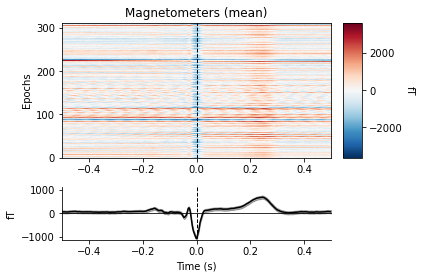

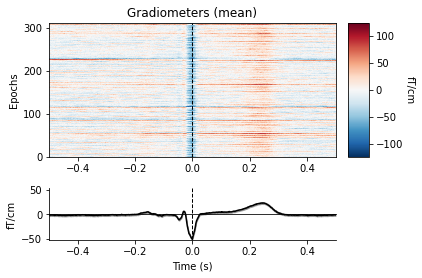

[<Figure size 432x288 with 3 Axes>, <Figure size 432x288 with 3 Axes>]

In [6]:
#THIS FUNCTION CREATES EPOCHS ON BASE OF ECG EVENTS. 
# It calls find_ecg_events internally, so no need to run previous cell for it.

%matplotlib inline


ecg_epochs = mne.preprocessing.create_ecg_epochs(raw_cropped)
ecg_epochs.plot_image(combine='mean')

Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 8)
8 projection items activated
SSP projectors applied...


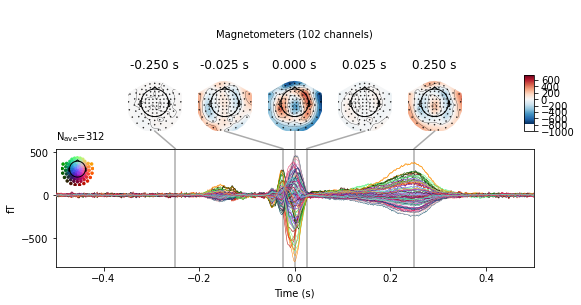

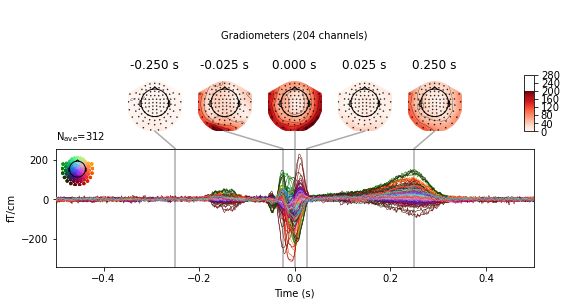

[<Figure size 576x302.4 with 9 Axes>, <Figure size 576x302.4 with 9 Axes>]

In [7]:
# Here I simply repeat the steps from mne tutorial:
# https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html#sphx-glr-auto-tutorials-preprocessing-10-preprocessing-overview-py

#averaging the ECG epochs together:
avg_ecg_epochs = ecg_epochs.average().apply_baseline((-0.5, -0.2))

avg_ecg_epochs.plot_joint(times=[-0.25, -0.025, 0, 0.025, 0.25])
# I guess 0 represents the actual ECG event and all around - the epoch and how the ECG signal developes during 
# the ECG epoch on everage over all channels?


In [ ]:
# THINK WHAT EXACTLY WE WANT TO RETURN AND SHOW THE USER AS QC



In [13]:
# Find EOG events:
# https://mne.tools/stable/generated/mne.preprocessing.find_eog_events.html

eog_events=mne.preprocessing.find_eog_events(raw, thresh=None, ch_name=None)
# threshfloat | None
# Threshold to trigger the detection of an EOG event. This controls the thresholding of the underlying 
# peak-finding algorithm. Larger values mean that fewer peaks (i.e., fewer EOG events) will be detected. 
# If None, use the default of (max(eog) - min(eog)) / 4, with eog being the filtered EOG signal.

# UNLIKE ECG, CAN NOT RECONSTRUCT EOG EVENTS IF NO DEDICATED CHANNEL IS PRESENT. SO EPOCHS CANT BE CREATED EITHER
# AS EOG channels it needs either: with type eog or ordinary EEG channel that was placed close to the eyes, like Fp1 or Fp2

# But we dont have any of these

# Another related function, but again needs EOG channel or other channels where EOG should be extracted from:
# https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA.find_bads_eog


/var/folders/h2/khhmb4p510vg63hbv0qkftt80000gs/T/ipykernel_32672/58517370.py:2: DeprecationWarning: No EOG channel found. Trying with EEG 061 and EEG 062. This functionality will be removed in version 0.24
  eog_events=mne.preprocessing.find_eog_events(raw, thresh=None, ch_name=None)


ValueError: Could not find any EOG channels.

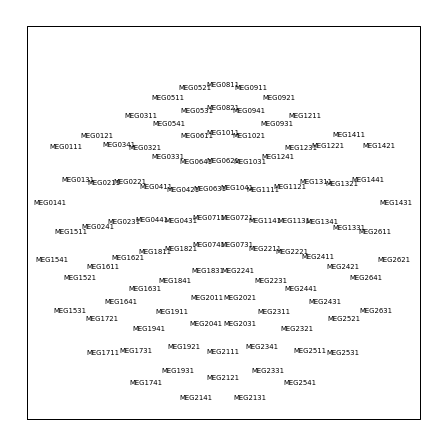

Using EOG channels: MEG0521, MEG0911, MEG0511, MEG0921
EOG channel index for this subject is: [ 59  62 101 104]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 17 significant peaks
Number of EOG events detected: 17


In [37]:

# "If you don’t have an EOG channel, find_bads_eog has a ch_name parameter that you can use as a proxy for EOG. 
# You can use a single channel, or create a bipolar reference from frontal EEG sensors and use that as virtual EOG channel. 
# This carries a risk however: you must hope that the frontal EEG channels only reflect EOG and not brain dynamics in 
# the prefrontal cortex (or you must not care about those prefrontal signals)."

# So here I plot the magnetometers layout, choose 4 magnetometers near the eyes and try to extract eyeblinks from there

# What is better mags or grads for eyeblinks reconstruction? Or both?

%matplotlib inline

layout_from_raw=mne.channels.find_layout(raw.info, ch_type='mag')
fig=layout_from_raw.plot()

eog_events=mne.preprocessing.find_eog_events(raw, thresh=1e-8, ch_name=['MEG0521', 'MEG0911', 'MEG0511', 'MEG0921'])
# Threshold to trigger the detection of an EOG event. This controls the thresholding of the underlying peak-finding algorithm. 
# Larger values mean that fewer peaks (i.e., fewer EOG events) will be detected. 
# If None, use the default of (max(eog) - min(eog)) / 4, with eog being the filtered EOG signal.

# Detected only 3 EOG events in th entire 1h dataset if threshold is set to defailt: thresh=None
# -> Try to adjust threshold or, maybe it just doesnt really work.
# -> Above: set the threshold to 1e-8, detects 17 eyeblink events - also too little. But I got no idea what threshold value is optimal.



Using EOG channels: MEG0521, MEG0911, MEG0511, MEG0921
EOG channel index for this subject is: [ 59  62 101 104]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 3 significant peaks
Number of EOG events detected: 3
Not setting metadata
Not setting metadata
3 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 8)
Loading data for 3 events and 1001 original tim

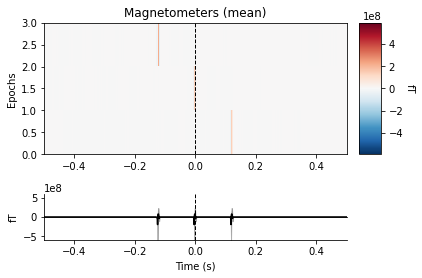

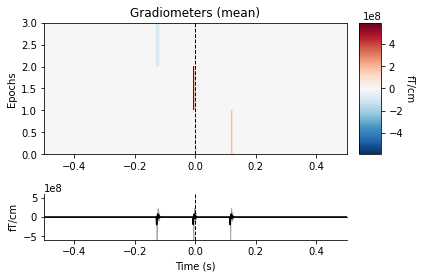

Created an SSP operator (subspace dimension = 8)
8 projection items activated
SSP projectors applied...


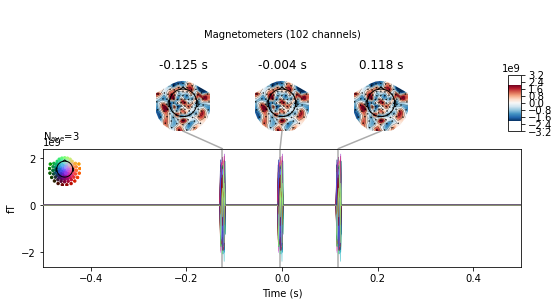

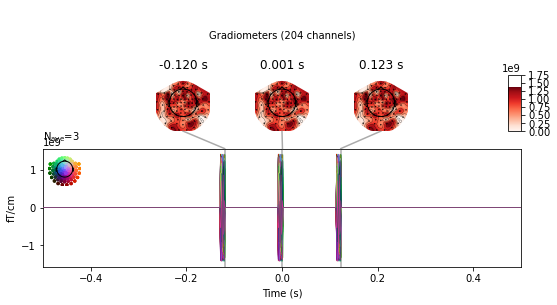

[<Figure size 576x302.4 with 7 Axes>, <Figure size 576x302.4 with 7 Axes>]

In [38]:
# So lets imagine the eyblink are detected correctly. Extract EOG epochs:

eog_epochs = mne.preprocessing.create_eog_epochs(raw, ch_name=['MEG0521', 'MEG0911', 'MEG0511', 'MEG0921'], baseline=(-0.5, -0.2))
#This function will internally call the find_eog_events again (no need to run previous cell). So I pass the chosen mag channels near the eyes again.


eog_epochs.plot_image(combine='mean')
eog_epochs.average().plot_joint()

#Looks definitely not the same as in preprocessing tutorial:
# https://mne.tools/stable/auto_tutorials/preprocessing/10_preprocessing_overview.html#sphx-glr-auto-tutorials-preprocessing-10-preprocessing-overview-py

#Should discuss what do we see here.


In [51]:
# Next, there is ICA used for ECG and EOG artifacts repair.
# https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html

# Functions ica_find_ecg_events and ica_find_eog_events - are not working independently, 
# they need to functions above to run first



In [ ]:
# found interesting function to fix stimulus artifacts: https://mne.tools/stable/generated/mne.preprocessing.fix_stim_artifact.html